<a href="https://colab.research.google.com/github/rato42/linear_regression/blob/unstable-yeah-sure/CLASSBASED_new_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [2338]:
import sys

# Detect Colab environment
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import drive, auth
    from googleapiclient.discovery import build
    from googleapiclient.http import MediaIoBaseDownload
    !pip install pwlf

    import pwlf

    auth.authenticate_user()
    drive.mount("/content/drive")
else:
    import pwlf
    from oauth2client.service_account import ServiceAccountCredentials

    print("Running outside Colab (VS Code/local)")

try:
    import gspread
except ModuleNotFoundError:
    if IN_COLAB and "google.colab" in str(get_ipython()):
        %pip install gspread
    import gspread

from gspread_dataframe import set_with_dataframe

Running outside Colab (VS Code/local)


In [2339]:

import os

import time

import math
import scipy.stats as stats
import pandas as pd
import numpy as np

from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Poisson
from statsmodels.genmod.cov_struct import Autoregressive

from scipy.stats import chi2
from sklearn.linear_model import Ridge
import statsmodels.api as sm
import copy

from openpyxl import load_workbook
from openpyxl.styles import Alignment

from scipy.stats import linregress, ttest_ind, ttest_rel, ttest_1samp
import matplotlib.pyplot as plt
import re
from openpyxl.drawing.image import Image
from matplotlib.font_manager import FontProperties
from io import BytesIO
import statsmodels.formula.api as smf
import statsmodels.api as sm

import numpy as np
import plotly.graph_objects as go


from datetime import datetime, timedelta

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from statsmodels.genmod.families import Gamma
from dateutil.relativedelta import relativedelta

from sklearn import set_config
set_config(display="diagram")

import logging
from typing import Dict, Any

import io

# LOAD --- data from gsheet if colab or local


In [2340]:
dados_brutos = None
output_wksheet = None

input_path = "https://docs.google.com/spreadsheets/d/1m3eEaxWT4Unb8jBZWKjiLivavfA0x3PT1F1Rz1eXwVE/edit?gid=0"
output_path = "https://docs.google.com/spreadsheets/d/1RzC3DfKNUwYA-qfUN0i53hUwRkWGMBOCoYQqdqG4MQY/edit?gid=0"

local_input_path = (
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input.csv" ### poa
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_backup_com_aps_total_RS.xlsx" ### rs
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_backup_com_aps_total.xlsx"
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_backup_com_aps_total_RS_percentual.xlsx"
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_IR_1000_poa.xlsx"
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_IR_1000_brasil.xlsx"
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\regions_IR_1000.xlsx"
    "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\raw_regions_joined.xlsx"
)

output_wksheet = None

if IN_COLAB:
    import gspread
    from google.auth import default

    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    workbook = gc.open_by_url(input_path)
    worksheets = workbook.worksheets()
    output_wksheet = gc.open_by_url(output_path)
    dados_brutos = worksheets[0].get_all_values()
else:
    try:
        dados_brutos = pd.read_csv(local_input_path, header=None).values.tolist()
    except:
        dados_brutos = pd.read_excel(local_input_path, header=None).values.tolist()

# TODO LIST

PROMPT
im doing a ITS. here is the structure
data is monthly, from 2016 to 2024
A PraisWinsten regression

the following dummies:
Pandemia_Step [2020 - 2022] - binary
Pandemia_Trend [2020 - 2022] - increase by 1 by period
PosPandemia_Step [2022 - 2024] - binary
PosPandemia_Trend [2022 - 2024] - increase by 1 by period
Lockdown 2020 [03/2020 - 05/2020] - pulse, binary
Locdown 2021 [04/2021 - 05/2021] - pulse, binary

In [2341]:
'''
Structured Prompt for Analysis

Study Context
I am conducting an Interrupted Time Series (ITS) analysis to evaluate the impact of the COVID-19 pandemic on mental health visit rates (per 1,000 total visits). The goal is to model changes in mental health visit rates before, during, and after the pandemic, adjusting for seasonality and underlying trends.
Data Structure

    Outcome: Count of mental health visits (integer).

    Predictors:

        Time variables (e.g., periodo, Pandemia_Step, Pandemia_Trend, PosPandemia_Step, PosPandemia_Trend).

        Seasonal controls (Fourier terms: cos1, sin1).

    Offset: log(total_visits / 1000) to model rates (visits per 1,000 total visits).

    Sample: 108 monthly observations.

Key Challenges

    Severe Overdispersion: Initial Poisson models show extreme overdispersion (Pearson χ²/df ≈ 456).

    Rate Modeling: Properly handling the offset to convert counts into rates.

Models Considered

    Poisson GLM with Offset

        Pros: Theoretically appropriate for count rates.

        Cons: Fails to address overdispersion, leading to underestimated SEs and inflated significance.

    Negative Binomial (NB) GLM with Offset

        Pros: Explicitly models overdispersion via dispersion parameter α.

        Cons: Requires careful interpretation of α in rate contexts.

    Quasi-Poisson with Manual SE Adjustment

        Pros: Adjusts SEs post-hoc using dispersion factor φ = Pearson χ² / df.

        Cons: Ad-hoc implementation in Python (no built-in support), lacks likelihood-based inference.

Key Results
Model    Dispersion Handling    Significant Findings
Poisson (naive)    None (ϕ=1 assumed)    Overly optimistic p-values (all significant)
Negative Binomial    Explicit (α ≈ 0.5)    Most effects non-significant post-adjustment
Quasi-Poisson (HC1)    Post-hoc SE scaling    Intermediate significance (e.g., PosPandemia_Trend p=0.015)
Question

Which model is most appropriate for valid inference?

    Does the Negative Binomial model’s use of an offset and dispersion parameter α create interpretational conflicts for rates?

    Is Quasi-Poisson with robust SEs (HC1) sufficient despite lacking a formal likelihood?

    Should I prioritize Poisson with robust SEs or switch to Negative Binomial?

Additional Context:

    Implementation is in Python (statsmodels).

    The final model must support hypothesis testing (e.g., step/trend changes during pandemic).

What’s the best approach?
'''

'\nStructured Prompt for Analysis\n\nStudy Context\nI am conducting an Interrupted Time Series (ITS) analysis to evaluate the impact of the COVID-19 pandemic on mental health visit rates (per 1,000 total visits). The goal is to model changes in mental health visit rates before, during, and after the pandemic, adjusting for seasonality and underlying trends.\nData Structure\n\n    Outcome: Count of mental health visits (integer).\n\n    Predictors:\n\n        Time variables (e.g., periodo, Pandemia_Step, Pandemia_Trend, PosPandemia_Step, PosPandemia_Trend).\n\n        Seasonal controls (Fourier terms: cos1, sin1).\n\n    Offset: log(total_visits / 1000) to model rates (visits per 1,000 total visits).\n\n    Sample: 108 monthly observations.\n\nKey Challenges\n\n    Severe Overdispersion: Initial Poisson models show extreme overdispersion (Pearson χ²/df ≈ 456).\n\n    Rate Modeling: Properly handling the offset to convert counts into rates.\n\nModels Considered\n\n    Poisson GLM with Of

In [2342]:
#Parte 1 – Análise geral com grupo controle
#
#    ITS com controle (como já falamos)
#
#    Mostra que saúde mental cresceu mais que os atendimentos gerais
#
#    Mostra os efeitos da pandemia nesse comportamento
#
#Parte 2 – Análise dos subgrupos (sem controle)
#
#    ITS separado para cada diagnóstico (ex: CID-10 F32, F41, etc.)
#
#    Sem grupo controle, mas comparando antes/depois da pandemia
#
#    Pode usar o mesmo modelo (Prais-Winsten com step + trend)

In [2343]:
#Omnibus Test: The high value (41.163) and the p-value (< 0.0001) 
# suggest that the residuals deviate from normality, which might indicate some model specification issues.
#
#Jarque-Bera Test: Similarly, this test suggests non-normality in the residuals.

In [2344]:
### to test if step is necessary

'''
import statsmodels.api as sm

# model with step
mod_full = sm.OLS(y, X_full).fit()

# model without step
mod_reduced = sm.OLS(y, X_reduced).fit()

# compare using F-test
f_test_result = mod_full.compare_f_test(mod_reduced)
'''

'\nimport statsmodels.api as sm\n\n# model with step\nmod_full = sm.OLS(y, X_full).fit()\n\n# model without step\nmod_reduced = sm.OLS(y, X_reduced).fit()\n\n# compare using F-test\nf_test_result = mod_full.compare_f_test(mod_reduced)\n'

In [2345]:
# TODO: Adicionar dummy de interação para comparar SM e outros atendimentos

# TODO: Orthogonalise pospand trend (so to not have colinearity with months)

# TODO: analisar overfitting

# TODO: taxa. a população se mantem estavel? os serviços de saude se mantem estaveis?

# https://chatgpt.com/canvas/shared/68084b682c548191a92db280344e5474

--- Low HIGH COMPLEXITY

- [x] Data Quality & Exploration  
  - [x] Plot the raw time series and annotate intervention points.  
  - [x] Check for missing values, outliers, or data entry errors.  
  - [x] Verify your date index is consistent (e.g., monthly frequency).  

- [x] Descriptive Statistics  
  - [x] Compute summary statistics (mean, variance) before and after the pandemic.  
  - [x] Calculate and plot moving averages to smooth trends.  

- [x] Dummy Variable Audit  
  - [x] Confirm each dummy is coded 0/1 for the correct periods.  
  - [x] Review naming consistency and placement in the DataFrame.  

- [x] Basic Model Fit  
  - [x] Fit the current segmented regression (consults ~ time + level_dummy + slope_dummy + month_dummies + lockdown_outliers).  
  - [x] Inspect R², coefficient signs, and p-values to sanity-check effects.  Export this to a readeable format

--- MEDIUM COMPLEXITY

- [ ] Residual Diagnostics  
  - [X] Plot residuals vs. fitted values to check heteroscedasticity.  
  - [ ] Examine ACF/PACF of residuals:  
    - [X] First using OLS (to confirm the need for AR structure).  
    - [X] Then using Prais-Winsten (to assess remaining autocorrelation).  

- [ ] Autocorrelation & Robust SE  
  - [ ] If autocorrelation exists, adjust standard errors (e.g., Newey-West) or fit an autoregressive error structure (e.g., AR(1)).  
  - [ ] Since you’re using Prais-Winsten, this step may be partially addressed — verify with residuals.  

- [ ] Seasonality & Trend Flexibility  
  - [ ] Test alternative seasonal structures (e.g., Fourier terms) instead of month dummies.  
  - [ ] Consider adding a quadratic or spline-based time trend.  

- [ ] Outlier Handling  
  - [ ] Justify and potentially consolidate lockdown outlier dummies (pulse vs. step).  
  - [ ] Compare models with and without these outlier dummies (use AIC/BIC).  

- [ ] Multicollinearity Check  
  - [ ] Compute Variance Inflation Factors (VIFs) for covariates.  

--- HIGH COMPLEXITY

- [ ] Adicionar dummy de interação para comparar SM e outros atendimentos

- [ ] Time-Series Cross-Validation  
  - [ ] Implement rolling-origin evaluation to assess predictive performance.  
  - [ ] Compare cross-validated errors (e.g., RMSE) across model specs to detect overfitting.  

- [ ] Model Comparison & Selection  
  - [ ] Use information criteria (AIC/BIC) to compare alternative models.  
  - [ ] Evaluate nested models (e.g., with/without slope change) via likelihood ratio tests.  

- [ ] Advanced Interrupted Time Series Methods  
  - [ ] Explore Bayesian ITS or segmented regression with autoregressive integrated moving average (ARIMA) errors.  
  - [x] Consider structural break tests (e.g., Chow test) for formal change-point detection.  

- [ ] Sensitivity & Robustness  
  - [ ] Run sensitivity analyses using different intervention start/end dates.  
  - [ ] Test robustness to alternative outlier definitions or lag structures.  

- [ ] Forecasting & Counterfactuals  
  - [ ] Generate counterfactual predictions for the post-pandemic period.  
  - [ ] Visualize observed vs. counterfactual to illustrate intervention impact.

In [2346]:
def build_model_formula(dependant_var, independant_var=False, dummy_names=[]):
    """
    Builds the regression formula dynamically.

    Parameters:
    -----------
    dependant_var : str
        The dependent variable (Y).
    independant_var : str or bool
        The independent variable (X). If False, it will be excluded.
    dummy_names : list
        List of dummy variable names to include in the formula.

    Returns:
    --------
    str
        The regression formula.
    """
    base_model_formula = f"{dependant_var} ~ "
    if independant_var:
        base_model_formula += f"{independant_var} + "

    # Add dummy variables (including Fourier terms if present)
    model_formula = base_model_formula
    if dummy_names:
        for i, dummy in enumerate(dummy_names):
            model_formula += dummy
            if i != len(dummy_names) - 1:  # Add '+' if not the last element
                model_formula += " + "

    return model_formula.strip(" + "), base_model_formula.strip(" + ")


def build_dummy_names(dummies_args, include_month_dummies, include_quarter_dummies, include_fourier_terms=False, n_harmonics=1):
    """
    Builds the list of dummy variable names dynamically.

    Parameters:
    -----------
    dummies_args : dict
        Dictionary of dummy variable configurations.
    include_month_dummies : bool
        Whether to include month dummies.
    include_quarter_dummies : bool
        Whether to include quarter dummies.
    include_fourier_terms : bool
        Whether to include Fourier terms for seasonality.
    n_harmonics : int
        Number of Fourier harmonics to include.

    Returns:
    --------
    list
        List of dummy variable names.
    """
    dummy_names = []

    # Add dummy variables from dummies_args
    for dummy_name in dummies_args.keys():
        dummy_names.append(dummy_name)

    # Add Fourier terms if enabled
    if include_fourier_terms:
        for k in range(1, n_harmonics + 1):
            dummy_names.append(f"cos{k}")
            dummy_names.append(f"sin{k}")

    # Add month dummies if enabled
    if include_month_dummies:
        for i in range(1, 12):
            dummy_names.append("month_" + str(i + 1))

    # Add quarter dummies if enabled
    if include_quarter_dummies:
        for i in range(1, 4):
            dummy_names.append("quarter_" + str(i + 1))

    return dummy_names


# ARGS --- Define Args


In [2382]:
### ARGS

MODEL_DEF = 'GLM'
RAW_ATD_VAR = 'mental_health_visits'
RAW_TOTAL_ATD_VAR = 'total_atd'
IR_VAR = 'IR'
IR_SCALE = 1000
DATE_NAME = "date"
GROUP_COL_NAME = "regiao"
LOCAL_OUTPUT_PATH = "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\output\\output.xlsx"


MAIN_SERIE = '_Grand Total'
CONTROL_SERIE = '__Atendimentos na APS (exceto saúde mental)'

MOVING_WINDOW = 12
PLOT_MEDIA_MOVEL = False

POISSON_QLIK = True

DO_CHOW_GRID_SEARCH = True 
### model vars
INDEPENDENT_VAR = "periodo"  ### Y
DEPENDENT_VAR = RAW_ATD_VAR if (MODEL_DEF == "GEE" or MODEL_DEF == "GLM") else IR_VAR


######### DUMMIES ##########

MEDIA_MOVEL_AS_FEATURE = False
MEDIA_MOVEL_AS_DEPENDENT = False

INCLUDE_FOURIER_TERMS = True
N_HARMONICS = 1
FOURIER_PERIOD = 12
INCLUDE_MONTH_DUMMIES = False
INCLUDE_QUARTER_DUMMIES = False

PRE_START_DATE = "2016-01-01"  ### data inicial para o modelo, se for menor que a data do dataframe, o modelo vai dar erro

### as quedas do primeiro lockdown nao são tão claras e a recuperação e queda parecem ser mais graduais
CHOQUE_INICIAL_START_DATE= "2020-04-01"
CHOQUE_INICIAL_END_DATE = "2020-07-01"#"2020-08-01" #month based

### abril e maio tiveram quedas bem identificaveis nos atendimentos em todas variavieis
SECONDLOCKDOWN_START_DATE = "2021-04-01"
SECONDLOCKDOWN_END_DATE = '2021-05-01' #month based  #'2021-04-01'#quarter_based #

PANDEMIA_START_DATE = "2020-04-01"
PANDEMIA_END_DATE = "2022-03-01" #"2021-02-01" #




PANDEMIA2_START_DATE = "2021-04-01"
PANDEMIA2_END_DATE = "2022-03-01" 

POS_PANDEMIA_START_DATE = "2022-04-01"
END_DATE = "2024-12-01"#"2024-12-01"  ### data final para o modelo, se for maior que a data do dataframe, o modelo vai dar erro




OMNICRON_START_DATE = "2022-01-01"
OMNICRON_END_DATE = "2022-02-01"  ### data final para o modelo, se for maior que a data do dataframe, o modelo vai dar erro



POS_PANDEMIA_EXCLUDE_RANGES = [
    #(CHOQUE_INICIAL_START_DATE, CHOQUE_INICIAL_END_DATE),
    #(SECONDLOCKDOWN_START_DATE, SECONDLOCKDOWN_END_DATE),
    #("2024-05-01", "2024-05-01"),
                               ]

PANDEMIA_EXCLUDE_RANGES = [
    #(CHOQUE_INICIAL_START_DATE, CHOQUE_INICIAL_END_DATE),
    #(SECONDLOCKDOWN_START_DATE, SECONDLOCKDOWN_END_DATE),
    #(OMNICRON_START_DATE, OMNICRON_END_DATE),
]

TESTE_REMOVE_OUTLIER_START = "2019-10-01"
TESTE_REMOVE_OUTLIER_END = "2019-12-01"  ### data final para o modelo, se for maior que a data do dataframe, o modelo vai dar erro
PREPANDEMIA_EXCLUDE_RANGES = [
    #(TESTE_REMOVE_OUTLIER_START, TESTE_REMOVE_OUTLIER_END),
]

TREND_KEEP_PERIOD_INDEX = False  ### se True, o modelo vai manter o index do periodo, se False, o modelo vai usar o index do dataframe original (sem os dummies)

DUMMY_ARGS =        {
        
        
        #'PrePandemia_Step': {"start_date": PRE_START_DATE, "end_date": PANDEMIA_START_DATE, 'exclude_ranges': PANDEMIA_EXCLUDE_RANGES,},
        #'PrePandemia_Trend' : {"start_date": PRE_START_DATE, "end_date": PANDEMIA_START_DATE,'exclude_ranges': PREPANDEMIA_EXCLUDE_RANGES, 'add_time_trend': True, 'keep_period_index': False},
        
        'Pandemia_Step': {"start_date": PANDEMIA_START_DATE, "end_date": PANDEMIA_END_DATE, 'exclude_ranges': PANDEMIA_EXCLUDE_RANGES,},
        'Pandemia_Trend' : {"start_date": PANDEMIA_START_DATE, "end_date": PANDEMIA_END_DATE,'exclude_ranges': PANDEMIA_EXCLUDE_RANGES, 'add_time_trend': True, 'keep_period_index': TREND_KEEP_PERIOD_INDEX},
        
        #'Pandemia2_Step': {"start_date": PANDEMIA2_START_DATE, "end_date": PANDEMIA2_END_DATE, 'exclude_ranges': PANDEMIA_EXCLUDE_RANGES,},
        #'Pandemia2_Trend' : {"start_date": PANDEMIA2_START_DATE, "end_date": PANDEMIA2_END_DATE,'exclude_ranges': PANDEMIA_EXCLUDE_RANGES, 'add_time_trend': True, 'keep_period_index': TREND_KEEP_PERIOD_INDEX},

        #'PosPandemia_Step': {"start_date": POS_PANDEMIA_START_DATE, "end_date": END_DATE,'exclude_ranges': POS_PANDEMIA_EXCLUDE_RANGES, 'plot':False, 'step': True,},
        #'PosPandemia_Trend' : {"start_date": POS_PANDEMIA_START_DATE, "end_date": END_DATE,'exclude_ranges': POS_PANDEMIA_EXCLUDE_RANGES, 'plot': True, 'add_time_trend': True, 'keep_period_index': TREND_KEEP_PERIOD_INDEX, 'step': False},
        
        ### Pulse Outliers
        #'teste_remove_outlier': {"start_date": TESTE_REMOVE_OUTLIER_START, "end_date": TESTE_REMOVE_OUTLIER_END,},
        #'Lockdown_2020_Step': {"start_date": CHOQUE_INICIAL_START_DATE, "end_date": CHOQUE_INICIAL_END_DATE},
        #'Lockdown_2021_Step': {"start_date": SECONDLOCKDOWN_START_DATE, "end_date": SECONDLOCKDOWN_END_DATE},
        #'Omnicron_2022': {"start_date": OMNICRON_START_DATE, "end_date": OMNICRON_END_DATE},
        #'Enchentes_2024': {"start_date": "2024-05-01", "end_date": "2024-05-01"},
        }



##############################


PREPROCESSOR_ARGS = {
    'DateRange': [2016, 2024],
    'FrequencyDateGroup' : 'M',
    'DummyArgs' : DUMMY_ARGS,
    'melt_total_atd': True,
    'ExtractIR': True,
}



###### PROCESSING ######


DUMMY_NAMES = build_dummy_names(
          DUMMY_ARGS,
          INCLUDE_MONTH_DUMMIES,
          INCLUDE_QUARTER_DUMMIES,
          include_fourier_terms=INCLUDE_FOURIER_TERMS,
          n_harmonics=N_HARMONICS,
          )

MODEL_FORMULA, BASE_MODEL_FORMULA = build_model_formula(DEPENDENT_VAR,
                                                        INDEPENDENT_VAR,
                                                        dummy_names = DUMMY_NAMES,

                                                        )



In [2348]:
MODEL_FORMULA, BASE_MODEL_FORMULA


('mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend + cos1 + sin1',
 'mental_health_visits ~ periodo')

# Processor ARGS


In [2349]:
GLSAR_PROCESSOR_ARGS = {
    "formula": MODEL_FORMULA,#"valores ~ periodo",  # Example formula
    "rho": 'define per variable',
    "fit_args":{
            'max_iter' : 100,
            "cov_type": "HAC",  # Use nonrobust covariance for testing
            "cov_kwds": {'maxlags': 4},  # No additional covariance arguments
    }

}

FIND_BEST_RHO_ARGS = {
        "start": -1.00,
        "stop": 1.01,
        "step": 0.01,
        "criterio": "aic",
    }
GEE_PROCESSOR_ARGS = {
    'formula': MODEL_FORMULA,
    "family": Poisson(),  #sm.families.NegativeBinomial(),# Use Poisson family for count data
    "cov_struct": Autoregressive(),  # Use autoregressive covariance structure
    #"structure": 'ar1',
    "groups": 'define per variable',
    "offset": 'define per variable',
    #'max_iter' : 100,
}

GLM_PROCESSOR_ARGS = {
    'formula': MODEL_FORMULA,
    "family": sm.families.NegativeBinomial(),# Poisson(),  # 
    'quasi_likelihood' : False,

    #"groups": 'define per variable',
    "offset": 'define per variable',
    "fit_args":{
            #'cov_type': 'HC1',
            'max_iter' : 100,
            "cov_type": "HAC",  # Use nonrobust covariance for testing
            "cov_kwds": {'maxlags': 4},  # No additional covariance arguments
    }
    #'max_iter' : 100,
}

if POISSON_QLIK:
 GLM_PROCESSOR_ARGS = {
    'formula': MODEL_FORMULA,
    "family": Poisson(),  # 
    'quasi_likelihood' : True,
    "offset": 'define per variable',
    "fit_args":{
            'cov_type': 'HC1',
            'max_iter' : 100,
            #"cov_type": "HAC",  # Use nonrobust covariance for testing
            #"cov_kwds": {'maxlags': 4},  # No additional covariance arguments
    }
    #'max_iter' : 100,
}
   
    

OLS_PROCESSOR_ARGS = {
    'formula': MODEL_FORMULA,
}


SARIMAX_PROCESSOR_ARGS = {
    
}

c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\cov_struct.py:796: FutureWarning:

grid=True will become default in a future version

c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.



# Define Preprocessors


In [2350]:
def BuildDataDF(data):
    string_dates = data[0][1:]  # Store original string dates

    # Converter as strings de datas em objetos datetime
    #date_list = [datetime.strptime(date, "%d/%m/%Y") for date in string_dates]
    date_list = [
    date if isinstance(date, datetime) else datetime.strptime(date, "%d/%m/%Y")
    for date in string_dates
    ]

    # Extrair os nomes das variáveis
    variavel = [row[0] for row in data[1:]]

    # Extrair os dados (sem agrupamento)
    dados = [row[1:] for row in data[1:]]
    dados = np.array(dados, dtype=float)  # Converter para tipo object para evitar warning

    # Criar o DataFrame with DatetimeIndex
    df = pd.DataFrame(data=dados, index=variavel, columns=pd.DatetimeIndex(date_list))

    return df

class DateFilterTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self, periodos_inclusivos=None, periodos_exclusivos=None, date_col=DATE_NAME
    ):
        self.periodos_inclusivos = periodos_inclusivos
        self.periodos_exclusivos = periodos_exclusivos
        self.date_col = date_col

    def get_date_range(self, Y1, Y2=None, M1=None, M2=None, D1=None, D2=None):
        Y2 = Y2 or Y1
        M1 = M1 or 1
        M2 = M2 or 12
        D1 = D1 or 1
        D2 = D2 or 31
        start_date = datetime(Y1, M1, D1)
        end_date = datetime(Y2, M2, D2)
        return pd.date_range(start=start_date, end=end_date, freq="D")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Convert date column if it's not datetime yet
        if not pd.api.types.is_datetime64_any_dtype(X[self.date_col]):
            X[self.date_col] = pd.to_datetime(X[self.date_col], errors="coerce")

        if self.periodos_inclusivos:
            valid_dates = self.get_date_range(*self.periodos_inclusivos)
            return X[X[self.date_col].isin(valid_dates)].reset_index(drop=True)

        elif self.periodos_exclusivos:
            invalid_dates = self.get_date_range(*self.periodos_exclusivos)
            return X[~X[self.date_col].isin(invalid_dates)].reset_index(drop=True)

        return X

class MeltTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        var_name=GROUP_COL_NAME,
        value_name=RAW_ATD_VAR,
        date_name=DATE_NAME,
        y_name=INDEPENDENT_VAR,
        perform_IR=False,
        total_suffix="_total",
        total_column_name=RAW_TOTAL_ATD_VAR,
    ):
        self.var_name = var_name
        self.value_name = value_name
        self.date_name = date_name
        self.y_name = y_name
        self.perform_IR = perform_IR
        self.total_suffix = total_suffix
        self.total_column_name = total_column_name

    def fit(self, X, y=None):
        # Nothing to learn, so just return self
        return self

    def transform(self, X):
        # Separate rows with the `_total` suffix
        if self.perform_IR:
            reserved_rows = X[X.index.str.endswith(self.total_suffix)]
            remaining_rows = X[~X.index.str.endswith(self.total_suffix)]

            # Transpose and reset index for the remaining rows
            df_long = remaining_rows.T.reset_index()

            # Rename index to date_name
            df_long = df_long.rename(columns={"index": self.date_name})

            # Melt the DataFrame
            df_long = pd.melt(
                df_long,
                id_vars=[self.date_name],
                var_name=self.var_name,
                value_name=self.value_name,
            )

            # Sort by category and date
            df_final = df_long.sort_values([self.var_name, self.date_name]).reset_index(
                drop=True
            )

            # Add the `total_atd` column
            reserved_rows = reserved_rows.T.reset_index().rename(columns={"index": self.date_name})
            reserved_rows_long = pd.melt(
                reserved_rows,
                id_vars=[self.date_name],
                var_name=self.var_name,
                value_name=self.total_column_name,
            )

            # Remove the `_total` suffix from the var_name in reserved_rows_long
            reserved_rows_long[self.var_name] = reserved_rows_long[self.var_name].str.replace(
                self.total_suffix, "", regex=False
            )

            # Merge the `total_atd` column into the final DataFrame
            df_final = df_final.merge(
                reserved_rows_long,
                on=[self.date_name, self.var_name],
                how="left",
            )
        else:
                        # Transpose and reset index for the remaining rows
            df_long = X.T.reset_index()

            # Rename index to date_name
            df_long = df_long.rename(columns={"index": self.date_name})

            # Melt the DataFrame
            df_long = pd.melt(
                df_long,
                id_vars=[self.date_name],
                var_name=self.var_name,
                value_name=self.value_name,
            )

            # Sort by category and date
            df_final = df_long.sort_values([self.var_name, self.date_name]).reset_index(
                drop=True
            )


        return df_final

class PeriodIndexAdder(BaseEstimator, TransformerMixin):
    def __init__(self, group_col=GROUP_COL_NAME, new_col=INDEPENDENT_VAR):
        self.group_col = group_col
        self.new_col = new_col
        self.period_date_mapping = {}  # Dictionary to store period-date equivalences

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.new_col] = X.groupby(self.group_col).cumcount() + 1

        #Store the mapping of periods to dates
        self.period_date_mapping = dict(zip(X[DATE_NAME], X[self.new_col]))
        #for group, group_data in X.groupby(self.group_col):
        #    self.period_date_mapping[group] = dict(zip(group_data[DATE_NAME], group_data[self.new_col]))

        return X

class DataFrameSorter(BaseEstimator, TransformerMixin):
    """
    Sorts a DataFrame by a specified column.

    Parameters:
    -----------
    sort_by : str
        Name of the column to sort by.
    ascending : bool, default=True
        Whether to sort in ascending order.
    """

    def __init__(self, sort_by, ascending=True):
        self.sort_by = sort_by
        self.ascending = ascending

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.sort_by not in X.columns:
            raise ValueError(f"Column '{self.sort_by}' not found in DataFrame.")
        return X.sort_values(by=self.sort_by, ascending=self.ascending).reset_index(drop=True)

class MonthlyDummyAdder(BaseEstimator, TransformerMixin):
    """
    Adds dummy variables for each month to control for seasonality, leaving December as the baseline.

    Parameters:
    -----------
    date_column : str
        Name of the column containing dates (must be datetime).
    """

    def __init__(self, date_column=DATE_NAME):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_column] = pd.to_datetime(X[self.date_column])  # Ensure dates are in datetime format

        # Extract month from the date column
        X['month'] = X[self.date_column].dt.month

        # Create dummy variables for each month, excluding December as the baseline
        month_dummies = pd.get_dummies(X['month'], prefix="month", drop_first=True).astype(int)



        # Concatenate the dummy variables with the original DataFrame
        X = pd.concat([X, month_dummies], axis=1)

        # Drop the temporary 'month' column
        X.drop(columns=['month'], inplace=True)

        return X

class QuarterlyDummyAdder(BaseEstimator, TransformerMixin):
    """
    Adds dummy variables for each quarter to control for seasonality, leaving Q4 as the baseline.

    Parameters:
    -----------
    date_column : str
        Name of the column containing dates (must be datetime).
    """

    def __init__(self, date_column=DATE_NAME):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_column] = pd.to_datetime(X[self.date_column])  # Ensure dates are in datetime format

        # Extract quarter from the date column
        X['quarter'] = X[self.date_column].dt.quarter

        # Create dummy variables for each quarter, excluding Q4 as the baseline
        quarter_dummies = pd.get_dummies(X['quarter'], prefix="quarter", drop_first=True).astype(int)

        # Concatenate the dummy variables with the original DataFrame
        X = pd.concat([X, quarter_dummies], axis=1)

        # Drop the temporary 'quarter' column
        X.drop(columns=['quarter'], inplace=True)

        return X

class MultiDummyAdder(BaseEstimator, TransformerMixin):
    """
    Adds multiple dummy variables based on date ranges or custom conditions.
    Allows each dummy to be binary or a local time trend via its own config.

    Parameters:
    -----------
    dummy_config : dict
        Dictionary defining dummy variables. Example:
        {
            'Pandemia': {
                'start_date': '2020-01-01',
                'end_date': '2020-12-31',
                'add_time_trend': True,
                'exclude_ranges': [
                    ('2020-04-01', '2020-05-01'),
                    ('2020-07-01', '2020-08-01')
                ]  # Optional
            }
        }
    date_column : str
        Name of the column containing dates (must be datetime).
    """

    def __init__(self, dummy_config, date_column=DATE_NAME):
        self.dummy_config = dummy_config
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_column] = pd.to_datetime(X[self.date_column])
        X = X.sort_values(self.date_column).reset_index(drop=True)

        for dummy_name, config in self.dummy_config.items():
            start_date = pd.to_datetime(config.get("start_date"))
            end_date = pd.to_datetime(config.get("end_date"))
            use_trend = config.get("add_time_trend", False)
            keep_index = config.get("keep_period_index", False)
            exclude_ranges = config.get("exclude_ranges", [])  # List of ranges to exclude

            if not start_date:
                raise ValueError(f"Missing 'start_date' for dummy '{dummy_name}'.")

            # Create the initial mask for the date range
            if end_date is not None:
                mask = (X[self.date_column] >= start_date) & (X[self.date_column] <= end_date)
            else:
                mask = X[self.date_column] >= start_date

            # Exclude multiple ranges within the period
            for excl_start, excl_end in exclude_ranges:
                excl_start = pd.to_datetime(excl_start)
                excl_end = pd.to_datetime(excl_end)
                mask &= ~((X[self.date_column] >= excl_start) & (X[self.date_column] <= excl_end))

            # Apply trend or binary dummy logic
            if use_trend:
                if keep_index:
                    # Global period multiplied by the dummy
                    X[dummy_name] = 0
                    X.loc[mask, dummy_name] = X.loc[mask, INDEPENDENT_VAR]
                else:
                    start_periodo = X.loc[mask, INDEPENDENT_VAR].min()
                    X[dummy_name] = 0
                    X.loc[mask, dummy_name] = (X.loc[mask, INDEPENDENT_VAR] - start_periodo + 1).clip(lower=0)
            else:
                X[dummy_name] = mask.astype(int)

        return X

class FrequencyGroupingTransformer(BaseEstimator, TransformerMixin):
    """
    ## only datetime supported groupings
    Transformer for grouping data by standard datetime frequencies.

    This transformer takes a DataFrame with datetime columns and groups
    the data by a specified frequency (e.g., 'Q' for quarterly, 'M' for monthly).

    ARGS:
        frequency (str): The frequency to group by. Defaults to 'Q' (quarterly).
                        Supported frequencies are those accepted by pd.Grouper (e.g., 'Q', 'M', 'Y').
    """

    def __init__(self, frequency="Q"):  # Default to quarterly grouping
        self.frequency = frequency

    def fit(self, X, y=None):
        """
        This transformer does not require fitting.

        ARGS:
            X (pd.DataFrame): The input DataFrame.
            y (Any, optional): Ignored. Defaults to None.

        Returns:
            self: Returns the transformer instance.
        """
        return self

    def transform(self, X):
        """
        Groups the data by the specified frequency and sums the values.

        ARGS:
            X (pd.DataFrame): The input DataFrame with datetime columns.

        Returns:
            pd.DataFrame: The grouped DataFrame with summed values.
                          Columns are datetime objects representing the end of each group.
        """
        if self.frequency == None or self.frequency == 'M':
            return X
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame.")



        # Convert columns to datetime if they are not already
        if not isinstance(X.columns[0], pd.Timestamp):
            X.columns = pd.to_datetime(X.columns, errors="coerce")

        # Group by the specified frequency using pd.Grouper
        grouped_df = X.T.groupby(pd.Grouper(freq=self.frequency)).sum().T

        return grouped_df







In [2351]:
class MovingAverageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col=GROUP_COL_NAME, date_col=DATE_NAME, value_col=DEPENDENT_VAR, window=3, prefix='ma', center=False):
        """
        window: tamanho da janela
        prefix: prefixo para o nome da nova coluna
        center: se True, a janela será centralizada
        """
        self.window = window
        self.prefix = prefix
        self.center = center
        self.value_col = value_col
        self.group_col = group_col
        self.date_col = date_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        def rolling_mean_by_group(group):
            group = group.sort_values(by=self.date_col)  # Sort by date within group
            new_col = f"{self.prefix}_{self.window}_{self.value_col}"
            group[new_col] = group[self.value_col].rolling(window=self.window, center=self.center, min_periods=1).mean()
            return group

        # Apply the rolling mean and reset the index to preserve the original structure
        X = X.groupby(self.group_col, group_keys=False).apply(rolling_mean_by_group)

        return X

In [2352]:
from statsmodels.tsa.deterministic import Fourier

class FourierSeasonalityAdder(BaseEstimator, TransformerMixin):
    def __init__(self, date_column=DATE_NAME, period=12, order=1):
        """
        Parameters:
        -----------
        date_column : str
            Name of the column containing dates (must be datetime).
        period : int
            The period of the seasonality (e.g., 12 for monthly data).
        order : int
            The number of Fourier harmonics to include.
        """
        self.date_column = date_column
        self.period = period
        self.order = order
        self.fourier = Fourier(period=self.period, order=self.order)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Ensure the date column is in datetime format
        X[self.date_column] = pd.to_datetime(X[self.date_column])

        # Ensure unique index
        if not X.index.is_unique:
            X = X.reset_index(drop=True)

        # Generate Fourier terms
        fourier_terms = self.fourier.in_sample(X[self.date_column])

        # Rename Fourier columns to use sin1, cos1, etc.
        renamed_columns = {col: f"sin{int(i/2)+1}" if i % 2 else f"cos{int(i/2)+1}" 
                           for i, col in enumerate(fourier_terms.columns)}
        fourier_terms.rename(columns=renamed_columns, inplace=True)

        # Concatenate Fourier terms with the original DataFrame
        X = pd.concat([X.reset_index(drop=True), fourier_terms.reset_index(drop=True)], axis=1)

        # Debugging: Check the range of Fourier terms
        for column in fourier_terms.columns:
            min_value = fourier_terms[column].min()
            max_value = fourier_terms[column].max()
            if min_value < -1 or max_value > 1:
                print(f"Warning: {column} is out of range [-1, 1]. Min: {min_value}, Max: {max_value}")
            else:
                print(f"{column} is within the correct range [-1, 1]. Min: {min_value}, Max: {max_value}")

        return X

# EXEC --- Instantiate Pipe and get RegressionDF

In [2353]:

pipe = Pipeline(
    [
        ("grouping", FrequencyGroupingTransformer(frequency=PREPROCESSOR_ARGS['FrequencyDateGroup'])),
        ("melt", MeltTransformer(perform_IR=PREPROCESSOR_ARGS['melt_total_atd'])),
        ("date_filter", DateFilterTransformer(periodos_inclusivos=PREPROCESSOR_ARGS['DateRange'])),
        ("period_index_adder", PeriodIndexAdder()),
        ("dummy_adder", MultiDummyAdder(dummy_config=PREPROCESSOR_ARGS['DummyArgs'])),
        ("monthly_dummy_adder", MonthlyDummyAdder()),
        ("quarterly_dummy_adder", QuarterlyDummyAdder()),
        ('fourier_seasonality', FourierSeasonalityAdder(period = FOURIER_PERIOD,order=N_HARMONICS)),
        
        ("sorter", DataFrameSorter(sort_by=GROUP_COL_NAME, ascending=False)),


    ]
)


RawDataDF = BuildDataDF(dados_brutos)
RegressionDF = pipe.fit_transform(RawDataDF)

if PREPROCESSOR_ARGS['ExtractIR']:
    RegressionDF[IR_VAR] =  RegressionDF[RAW_ATD_VAR]/RegressionDF[RAW_TOTAL_ATD_VAR] * IR_SCALE

if RegressionDF[RAW_TOTAL_ATD_VAR] is not None:
    RegressionDF["offset"] = np.log(RegressionDF["total_atd"] / IR_SCALE)


pipe_MA = Pipeline(
    [
        ('moving_average', MovingAverageTransformer(window=MOVING_WINDOW, prefix='ma', center=True)),
    ]
)

RegressionDF = pipe_MA.fit_transform(RegressionDF)

RegressionDF


C:\Users\Lucas\AppData\Local\Temp\ipykernel_25208\822946302.py:28: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



cos1 is within the correct range [-1, 1]. Min: -1.0, Max: 1.0
sin1 is within the correct range [-1, 1]. Min: -1.0, Max: 1.0


,date,regiao,mental_health_visits,total_atd,periodo,Pandemia_Step,Pandemia_Trend,month_2,month_3,month_4,...,month_11,month_12,quarter_2,quarter_3,quarter_4,cos1,sin1,IR,offset,ma_12_mental_health_visits
647,2016-01-01,Brasil,111066.0,8232396.0,1,0,0,0,0,0,...,0,0,0,0,0,0.000000e+00,1.000000e+00,13.491334,9.015832,134095.000000
541,2016-02-01,Brasil,122505.0,10104083.0,2,0,0,1,0,0,...,0,0,0,0,0,-5.000000e-01,8.660254e-01,12.124307,9.220695,135568.142857
581,2016-03-01,Brasil,149843.0,13130885.0,3,0,0,0,1,0,...,0,0,0,0,0,-2.449294e-16,1.000000e+00,11.411493,9.482722,140360.375000
572,2016-04-01,Brasil,129201.0,11242471.0,4,0,0,0,0,1,...,0,0,1,0,0,-1.000000e+00,-4.286264e-16,11.492224,9.327454,142256.666667
563,2016-05-01,Brasil,137556.0,11755506.0,5,0,0,0,0,0,...,0,0,1,0,0,8.660254e-01,5.000000e-01,11.701410,9.372077,142070.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2024-08-01,sul,227340.0,7427441.0,104,0,0,0,0,0,...,0,0,0,1,0,3.037743e-14,-1.000000e+00,30.608119,8.912937,210028.454545
107,2024-09-01,sul,220966.0,7304922.0,105,0,0,0,0,0,...,0,0,0,1,0,5.000000e-01,-8.660254e-01,30.248920,8.896304,211300.500000
106,2024-10-01,sul,239779.0,8045022.0,106,0,0,0,0,0,...,0,0,0,0,1,-8.660254e-01,-5.000000e-01,29.804642,8.992809,212677.777778
86,2024-11-01,sul,204838.0,6753619.0,107,0,0,0,0,0,...,1,0,0,0,1,8.660254e-01,5.000000e-01,30.330109,8.817834,210275.875000


In [2354]:
GEE_PROCESSOR_ARGS

{'formula': 'mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend + cos1 + sin1',
 'family': <statsmodels.genmod.families.family.Poisson at 0x1d91c553ce0>,
 'cov_struct': <statsmodels.genmod.cov_struct.Autoregressive at 0x1d91c553080>,
 'groups': 'define per variable',
 'offset': 'define per variable'}

# Exploração pressupostos

In [2355]:
print("=== Mean-Variance Check by Region ===")
for region in RegressionDF[GROUP_COL_NAME].unique():
    region_df = RegressionDF[RegressionDF[GROUP_COL_NAME] == region]
    print(f"\nRegion: {region}")
    print(f"Mean: {region_df[DEPENDENT_VAR].mean():.2f}")
    print(f"Variance: {region_df[DEPENDENT_VAR].var():.2f}")
    print(f"Variance/Mean Ratio: {region_df[DEPENDENT_VAR].var()/region_df[DEPENDENT_VAR].mean():.2f}")

=== Mean-Variance Check by Region ===

Region: Brasil
Mean: 510467.23
Variance: 82712134212.80
Variance/Mean Ratio: 162032.21

Region: centro_oeste
Mean: 38116.95
Variance: 480013434.79
Variance/Mean Ratio: 12593.17

Region: nordeste
Mean: 102633.95
Variance: 5168958822.62
Variance/Mean Ratio: 50363.05

Region: norte
Mean: 19892.93
Variance: 176968899.12
Variance/Mean Ratio: 8896.07

Region: sudeste
Mean: 218776.52
Variance: 15659822279.04
Variance/Mean Ratio: 71579.08

Region: sul
Mean: 121398.41
Variance: 2685416574.49
Variance/Mean Ratio: 22120.69


In [2356]:
print("\n=== Mean-Variance by Region: Pre-Intervention vs Intervention ===")
'''
for region in RegressionDF[GROUP_COL_NAME].unique():
    # Pre-intervention subset (both pandemic indicators = 0)
    pre_subset = RegressionDF[(RegressionDF[GROUP_COL_NAME] == region) & 
                            (RegressionDF['Pandemia_Step'] == 0) &
                            (RegressionDF['PosPandemia_Step'] == 0)]
    
    # Intervention subset (all other cases)
    int_subset = RegressionDF[(RegressionDF[GROUP_COL_NAME] == region) & 
                            ((RegressionDF['Pandemia_Step'] != 0) |
                             (RegressionDF['PosPandemia_Step'] != 0))]
    
    print(f"\nRegion: {region}")
    
    # Pre-intervention stats
    if len(pre_subset) > 0:
        print("  PRE-INTERVENTION:")
        print(f"  N observations: {len(pre_subset)}")
        print(f"  Mean: {pre_subset[DEPENDENT_VAR].mean():.2f}")
        print(f"  Variance: {pre_subset[DEPENDENT_VAR].var():.2f}")
        print(f"  Dispersion ratio: {pre_subset[DEPENDENT_VAR].var()/pre_subset[DEPENDENT_VAR].mean():.2f}")
    else:
        print("  No pre-intervention data for this region")
    
    # Intervention stats
    if len(int_subset) > 0:
        print("  INTERVENTION:")
        print(f"  N observations: {len(int_subset)}")
        print(f"  Mean: {int_subset[DEPENDENT_VAR].mean():.2f}")
        print(f"  Variance: {int_subset[DEPENDENT_VAR].var():.2f}")
        print(f"  Dispersion ratio: {int_subset[DEPENDENT_VAR].var()/int_subset[DEPENDENT_VAR].mean():.2f}")
    else:
        print("  No intervention data for this region")
'''


=== Mean-Variance by Region: Pre-Intervention vs Intervention ===


'\nfor region in RegressionDF[GROUP_COL_NAME].unique():\n    # Pre-intervention subset (both pandemic indicators = 0)\n    pre_subset = RegressionDF[(RegressionDF[GROUP_COL_NAME] == region) & \n                            (RegressionDF[\'Pandemia_Step\'] == 0) &\n                            (RegressionDF[\'PosPandemia_Step\'] == 0)]\n    \n    # Intervention subset (all other cases)\n    int_subset = RegressionDF[(RegressionDF[GROUP_COL_NAME] == region) & \n                            ((RegressionDF[\'Pandemia_Step\'] != 0) |\n                             (RegressionDF[\'PosPandemia_Step\'] != 0))]\n    \n    print(f"\nRegion: {region}")\n    \n    # Pre-intervention stats\n    if len(pre_subset) > 0:\n        print("  PRE-INTERVENTION:")\n        print(f"  N observations: {len(pre_subset)}")\n        print(f"  Mean: {pre_subset[DEPENDENT_VAR].mean():.2f}")\n        print(f"  Variance: {pre_subset[DEPENDENT_VAR].var():.2f}")\n        print(f"  Dispersion ratio: {pre_subset[DEPENDENT_VA

# CHOW

In [2387]:

import numpy as np
import pandas as pd
import statsmodels.api as sm
import patsy
from scipy import stats

def chow_test_glm_by_date(df, 
                           y_col=None, X_cols=None, 
                           formula=None, 
                           breakpoint_date=None, 
                           family=None, 
                           offset_col=None, 
                           date_col='DATE_NAME'):
    """
    Faz o Chow Test em GLM, usando data como ponto de quebra.
    
    Pode passar (y_col + X_cols) ou formula.
    """

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # Subsets
    df1 = df[df[date_col] < pd.to_datetime(breakpoint_date)]
    df2 = df[df[date_col] >= pd.to_datetime(breakpoint_date)]

    # Se for fórmula
    if formula:
        y_full, X_full = patsy.dmatrices(formula, data=df, return_type='dataframe')
        y1, X1 = patsy.dmatrices(formula, data=df1, return_type='dataframe')
        y2, X2 = patsy.dmatrices(formula, data=df2, return_type='dataframe')
    else:
        X_full = sm.add_constant(df[X_cols])
        X1 = sm.add_constant(df1[X_cols])
        X2 = sm.add_constant(df2[X_cols])

        y_full = df[y_col]
        y1 = df1[y_col]
        y2 = df2[y_col]

    # Offsets
    offset_full = np.log(df[offset_col]) if offset_col else None
    offset1 = np.log(df1[offset_col]) if offset_col else None
    offset2 = np.log(df2[offset_col]) if offset_col else None

    fit_args = {            
            "cov_type": "HAC",  # Use nonrobust covariance for testing
            "cov_kwds": {'maxlags': 4},}
    # Ajuste dos modelos
    model_full = sm.GLM(y_full, X_full, family=family, offset=offset_full).fit()#**fit_args)
    model1 = sm.GLM(y1, X1, family=family, offset=offset1).fit()#**fit_args)
    model2 = sm.GLM(y2, X2, family=family, offset=offset2).fit()#**fit_args)

    # Log-Likelihoods
    ll_full = model_full.llf
    ll1 = model1.llf
    ll2 = model2.llf

    # Estatística de teste
    LR = 2 * ((ll1 + ll2) - ll_full)
    df_diff = (model1.df_model + model2.df_model) - model_full.df_model
    p_value = 1 - stats.chi2.cdf(LR, df_diff)

    return {
        'LR': LR,
        'p-value': p_value,
        'df_diff': df_diff
    }



In [2388]:
def chow_gridsearch_glm_by_date(RegressionDF, 
                                MODEL_FORMULA, 
                                candidate_dates, 
                                GROUP_COL_NAME, 
                                family, 
                                offset_col=None, 
                                date_col='DATE_NAME'):
    """
    Faz Chow Test para vários breakpoints possíveis,
    para cada grupo (ex: cidade, região etc.)
    
    Retorna um DataFrame com todos os resultados.
    """
    
    results = []

    for variable in RegressionDF[GROUP_COL_NAME].unique():
        variable_data = RegressionDF[RegressionDF[GROUP_COL_NAME] == variable].sort_values(by=date_col)
        variable_data = variable_data.reset_index(drop=True)

        for breakpoint_date in candidate_dates:
            chow_result = chow_test_glm_by_date(
                variable_data,
                formula=MODEL_FORMULA,
                breakpoint_date=breakpoint_date,
                family=family,
                offset_col=offset_col,
                date_col=date_col
            )
            results.append({
                'group': variable,
                'breakpoint': pd.to_datetime(breakpoint_date),
                'LR_stat': chow_result['LR'],
                'p_value': chow_result['p-value'],
                'df_diff': chow_result['df_diff']
            })

    # Organiza resultado final
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(['group', 'p_value'])  # ordena por menor p-valor primeiro
    
    return results_df


In [2389]:
candidate_dates = pd.date_range('2016-01-01', '2024-12-01', freq='M')

if DO_CHOW_GRID_SEARCH:
    chow_grid_results = chow_gridsearch_glm_by_date(
        RegressionDF=RegressionDF,
        MODEL_FORMULA=MODEL_FORMULA,
        candidate_dates=candidate_dates,
        GROUP_COL_NAME=GROUP_COL_NAME,
        family=sm.families.NegativeBinomial(),
        offset_col='offset',
        date_col=DATE_NAME
    )
    chow_grid_results
chow_grid_results

C:\Users\Lucas\AppData\Local\Temp\ipykernel_25208\656223074.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.

c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\_tools.py:121: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\_tools.py:121: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\Lucas\AppData\Local\Programs\Py

,group,breakpoint,LR_stat,p_value,df_diff
105,Brasil,2024-10-31,0.168219,0.681700,1
1,Brasil,2016-02-29,0.136569,0.711716,1
18,Brasil,2017-07-31,1.213233,0.749832,3
19,Brasil,2017-08-31,1.192079,0.754905,3
33,Brasil,2018-10-31,1.181921,0.757344,3
...,...,...,...,...,...
597,sul,2021-03-31,0.067118,0.999939,5
596,sul,2021-02-28,0.066869,0.999940,5
595,sul,2021-01-31,0.066446,0.999941,5
535,sul,2016-01-31,0.113118,NaN,0


In [2361]:
#plt.boxplot([RegressionDF[RegressionDF['regiao']==r][DEPENDENT_VAR] 
#            for r in RegressionDF['regiao'].unique()])
#plt.yscale('log')  # Log-scale due to huge range
#plt.xticks(ticks=range(1,6), labels=RegressionDF['regiao'].unique())
#plt.title("Mental Health Visits by Region (Log Scale)")

# Exploração Pré intervenção


In [2362]:
def run_pre_intervention_diagnostics(data, date_col, dependent_var, intervention_start_date):
    """
    Realiza testes diagnósticos no período pré-intervenção.

    Args:
        data (pd.DataFrame): DataFrame contendo os dados.
        date_col (str): Nome da coluna de datas.
        dependent_var (str): Nome da variável dependente.
        intervention_start_date (str): Data de início da intervenção (formato 'YYYY-MM-DD').

    Returns:
        dict: Resultados dos testes diagnósticos.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.stats.diagnostic import het_breuschpagan
    from statsmodels.stats.stattools import durbin_watson
    from scipy.stats import shapiro, jarque_bera, normaltest
    import statsmodels.api as sm

    # Filtrar o período pré-intervenção
    pre_intervention_df = data[data[date_col] < pd.to_datetime(intervention_start_date)]

    # Inicializar resultados
    results = {}

    # 1. Teste de Estacionariedade (ADF)
    y = pre_intervention_df[dependent_var]
    adf_result = adfuller(y)
    results['ADF Statistic'] = adf_result[0]
    results['ADF p-value'] = adf_result[1]
    results['ADF Stationary'] = adf_result[1] < 0.05

    # 2. Diagnóstico de Autocorrelação (ACF e PACF)
    results['ACF'] = "Plotted"
    results['PACF'] = "Plotted"

    # 3. Teste de Heterocedasticidade (Breusch-Pagan)
    X = sm.add_constant(pre_intervention_df.index)  # Índice como variável independente
    model = sm.OLS(y, X).fit()
    bp_test = het_breuschpagan(model.resid, X)
    results['Breusch-Pagan LM Statistic'] = bp_test[0]
    results['Breusch-Pagan p-value'] = bp_test[1]
    results['Heteroscedasticity'] = bp_test[1] < 0.05

    # 4. Testes de Normalidade dos Resíduos
    shapiro_test = shapiro(model.resid)
    jb_test = jarque_bera(model.resid)
    dagostino_test = normaltest(model.resid)
    results['Shapiro-Wilk p-value'] = shapiro_test.pvalue
    results['Jarque-Bera p-value'] = jb_test[1]
    results['D\'Agostino p-value'] = dagostino_test.pvalue
    results['Normality'] = all(p > 0.05 for p in [shapiro_test.pvalue, jb_test[1], dagostino_test.pvalue])

    # 5. Teste de Autocorrelação (Durbin-Watson)
    dw_stat = durbin_watson(model.resid)
    results['Durbin-Watson Statistic'] = dw_stat
    results['No Autocorrelation'] = 1.5 < dw_stat < 2.5

    return results


# Consolidar os resultados em um DataFrame
diagnostics_results = []

try:
    for variable in RegressionDF[GROUP_COL_NAME].unique():
        print(f"Analisando variável: {variable}")
        variable_df = RegressionDF[RegressionDF[GROUP_COL_NAME] == variable].copy()
        diagnostics = run_pre_intervention_diagnostics(
            data=variable_df,
            date_col=DATE_NAME,
            dependent_var=DEPENDENT_VAR,
            intervention_start_date=PANDEMIA_START_DATE
        )
        diagnostics['Variable'] = variable  # Adicionar o nome da variável ao resultado
        diagnostics_results.append(diagnostics)
    
    # Criar um DataFrame com os resultados
    diagnostics_df = pd.DataFrame(diagnostics_results)
    diagnostics_df.set_index('Variable', inplace=True)
    
    # Exibir o DataFrame
    diagnostics_df
except:
    print("could not do pre-intervention diagnostic")

Analisando variável: Brasil
Analisando variável: centro_oeste
Analisando variável: nordeste
Analisando variável: norte
Analisando variável: sudeste
Analisando variável: sul


# Media movel 

In [2363]:
import matplotlib.pyplot as plt



moving_avg_pipe = Pipeline([
    ('moving_average', MovingAverageTransformer(window=MOVING_WINDOW, prefix='ma', center=True)),
    ]
    )

def plot_moving_average(df, column, ma_column=None, title='Moving Average Plot', date_column='date'):
    """
    Plota a série temporal original junto com a média móvel.

    df: DataFrame contendo os dados
    column: nome da coluna original
    ma_column: nome da coluna da média móvel (se None, assume padrão de 'ma_{window}_{column}')
    title: título do gráfico
    date_column: nome da coluna de data
    """
    if ma_column is None:
        ma_column = [col for col in df.columns if col.startswith('ma_') and col.endswith(column)]
        if ma_column:
            ma_column = ma_column[0]
        else:
            raise ValueError("Média móvel não encontrada. Verifique o nome da coluna.")

    df[date_column] = pd.to_datetime(df[date_column])  # Ensure datetime format

    plt.figure(figsize=(12, 5))
    plt.plot(df[date_column], df[column], label='Original', color='lightgray')
    plt.plot(df[date_column], df[ma_column], label=f'{ma_column}', color='blue')
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if PLOT_MEDIA_MOVEL:
    for var in RegressionDF[GROUP_COL_NAME].unique():
        var_df = RegressionDF[RegressionDF[GROUP_COL_NAME] == var]
        #var_df = var_df.sort_values(by = INDEPENDENT_VAR, ascending=False)
        #print(var_df)
        #var_df = moving_avg_pipe.fit_transform(var_df)


        plot_moving_average(var_df, column=DEPENDENT_VAR, ma_column=f'ma_{MOVING_WINDOW}_{DEPENDENT_VAR}', title=f'Moving Average Plot for {var}')



# Get Period Date Map and Dummies Period Indexes

In [2364]:
PERIOD_DATE_MAP = pipe.named_steps['period_index_adder'].period_date_mapping

In [2365]:
def find_idx_from_date(target_date, args, period_date_map=PERIOD_DATE_MAP):
    """
    Finds the 'periodo' (index) corresponding to a given datetime in the PERIOD_DATE_MAP.

    Args:
        target_date (str or datetime): The target date to search for (e.g., '2020-01-01').
        period_date_map (dict): The PERIOD_DATE_MAP containing period-to-date mappings.

    Returns:
        int: The 'periodo' (index) corresponding to the target date, or None if not found.
    """
    # Ensure the target_date is a datetime object and normalize to quarter-end
    if isinstance(target_date, str):
        target_date = pd.to_datetime(target_date)
    if args['FrequencyDateGroup'] == 'Q' or args['FrequencyDateGroup'] == 'QE':
        target_date = target_date + pd.offsets.QuarterEnd(0)

    # Iterate through the PERIOD_DATE_MAP to find the matching period
    for date, period in period_date_map.items():
        if isinstance(date, str):
            date = pd.to_datetime(date)
        if args['FrequencyDateGroup'] == 'Q' or args['FrequencyDateGroup'] == 'QE':
            date = date + pd.offsets.QuarterEnd(0) # Normalize to quarter-end
        if date == target_date:
            return period - 1

    return None


def find_date_from_idx(target_idx, args, period_date_map=PERIOD_DATE_MAP):
    """
    Finds the date corresponding to a given 'periodo' (index) in the PERIOD_DATE_MAP.

    Args:
        target_idx (int): The target index to search for (e.g., 1, 2, 3).
        period_date_map (dict): The PERIOD_DATE_MAP containing period-to-date mappings.

    Returns:
        datetime or None: The date corresponding to the target index, or None if not found.
    """
    # Iterate through the PERIOD_DATE_MAP to find the matching index
    for date, period in period_date_map.items():
        if period == target_idx:
            date = pd.to_datetime(date) if isinstance(date, str) else date
            date = date + pd.offsets.QuarterEnd(0) if args['FrequencyDateGroup'] == 'Q' or args['FrequencyDateGroup'] == 'QE' else date
            return date
    return None

In [2366]:
DummyIndexes = {}

# Iterate over DUMMY_ARGS to calculate and store indexes
for dummy_name, config in DUMMY_ARGS.items():
    start_date = config.get("start_date")
    end_date = config.get("end_date")

    print(dummy_name, config)
    # Calculate indexes using find_idx_from_date
    start_idx = find_idx_from_date(start_date, PREPROCESSOR_ARGS, PERIOD_DATE_MAP) if start_date else None
    end_idx = find_idx_from_date(end_date, PREPROCESSOR_ARGS, PERIOD_DATE_MAP) if end_date else None

    # Store the indexes in the table
    DummyIndexes[dummy_name] = {
        "start_index": start_idx,
        "end_index": end_idx
    }
DummyIndexes

Pandemia_Step {'start_date': '2020-04-01', 'end_date': '2022-03-01', 'exclude_ranges': []}
Pandemia_Trend {'start_date': '2020-04-01', 'end_date': '2022-03-01', 'exclude_ranges': [], 'add_time_trend': True, 'keep_period_index': False}


{'Pandemia_Step': {'start_index': 51, 'end_index': 74},
 'Pandemia_Trend': {'start_index': 51, 'end_index': 74}}

# OLD TRASH Exploration


In [2367]:
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant
import pandas as pd
from scipy.stats import f
main_regrdf = RegressionDF.copy()
def chow_test(data, split_point, dependent_var, independent_vars):
    """
    Realiza o teste de Chow para verificar mudanças estruturais em um modelo de regressão.

    Args:
        data (pd.DataFrame): DataFrame contendo os dados.
        split_point (int): Ponto de divisão para o teste de Chow.
        dependent_var (str): Nome da variável dependente.
        independent_vars (list): Lista de nomes das variáveis independentes.

    Returns:
        dict: Resultados do teste de Chow contendo os valores F e p.
    """
    # Dividir os dados em dois subconjuntos
    data1 = data[data['periodo'] <= split_point]
    data2 = data[data['periodo'] > split_point]

    # Ajustar os modelos para cada subconjunto
    X1 = add_constant(data1[independent_vars])
    y1 = data1[dependent_var]
    model1 = OLS(y1, X1).fit()

    X2 = add_constant(data2[independent_vars])
    y2 = data2[dependent_var]
    model2 = OLS(y2, X2).fit()

    # Ajustar o modelo para o conjunto completo
    X_full = add_constant(data[independent_vars])
    y_full = data[dependent_var]
    model_full = OLS(y_full, X_full).fit()

    # Calcular os graus de liberdade
    k = len(independent_vars) + 1  # Número de parâmetros (incluindo o intercepto)
    n1 = len(data1)
    n2 = len(data2)
    n = n1 + n2

    # Calcular a soma dos quadrados dos resíduos
    RSS1 = model1.ssr
    RSS2 = model2.ssr
    RSS_full = model_full.ssr

    # Calcular o valor F
    F = ((RSS_full - (RSS1 + RSS2)) / k) / ((RSS1 + RSS2) / (n - 2 * k))

    # Calcular o p-valor
    p_value = 1 - f.cdf(F, k, n - 2 * k)

    return {"F-statistic": F, "p-value": p_value}


if False:
    chow_results = {}
    split_point = find_idx_from_date(POS_PANDEMIA_START_DATE, PREPROCESSOR_ARGS)  # Exemplo: ponto de divisão para o teste de Chow
    dependent_var = DEPENDENT_VAR
    independent_vars = [INDEPENDENT_VAR] #+ [key for key in DUMMY_ARGS.keys()]
    for variable in main_regrdf[GROUP_COL_NAME].unique():
        variable_data = main_regrdf[main_regrdf[GROUP_COL_NAME] == variable]
        result = chow_test(variable_data, split_point, dependent_var, independent_vars)
        chow_results[variable] = result
    # Converter os resultados em um DataFrame para visualização
    chow_results_df = pd.DataFrame(chow_results).T
    chow_results_df.columns = ["F-statistic", "p-value"]
    chow_results_df['p-value'] = chow_results_df['p-value'].round(8)
    print(chow_results_df)

In [2368]:
### TODO: make the knots per variable
### TODO: remove the bumps/step_dummies before testing

pwmodel = pwlf.PiecewiseLinFit(main_regrdf[INDEPENDENT_VAR].values,main_regrdf[DEPENDENT_VAR].values)
knots = pwmodel.fit(2)
print(knots)
for knot in knots:
    print(find_date_from_idx(np.round(knot), PREPROCESSOR_ARGS, PERIOD_DATE_MAP))

[  1.          64.00000011 108.        ]
2016-01-01 00:00:00
2021-04-01 00:00:00
2024-12-01 00:00:00


In [2369]:
import pandas as pd
import numpy as np
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, normaltest, jarque_bera
import statsmodels.api as sm

def analyze_time_series(df: pd.DataFrame, variable_col: str, date_col: str, value_col: str):
    """
    Analyzes a melted DataFrame for heteroscedasticity, distribution, and autocorrelation.

    Parameters:
        df (pd.DataFrame): Melted DataFrame with columns for variable, date, and value.
        variable_col (str): Column name for the variable identifier.
        date_col (str): Column name for the date.
        value_col (str): Column name for the value.

    Returns:
        dict: A dictionary with analysis results for each variable.
    """
    results = {}

    for variable in df[variable_col].unique():
        # Filter data for the current variable
        variable_data = df[df[variable_col] == variable].sort_values(by=date_col)
        y = variable_data[value_col].values
        x = np.arange(len(y))  # Time index as independent variable

        # Add constant for regression
        X = sm.add_constant(x)

        # Fit OLS model
        model = sm.OLS(y, X).fit()

        # Heteroscedasticity tests
        bp_test = het_breuschpagan(model.resid, X)
        bp_pvalue = bp_test[1]

        # Normality tests
        shapiro_test = shapiro(model.resid)
        shapiro_pvalue = shapiro_test.pvalue

        jb_test = jarque_bera(model.resid)
        jb_pvalue = jb_test[1]

        dagostino_test = normaltest(model.resid)
        dagostino_pvalue = dagostino_test.pvalue

        # Autocorrelation tests
        dw_stat = durbin_watson(model.resid)
        ljungbox_test = acorr_ljungbox(model.resid, lags=[10], return_df=True)
        ljungbox_pvalue = ljungbox_test['lb_pvalue'].iloc[0]

        # Store results
        results[variable] = {
            "Heteroscedasticity (Breusch-Pagan)": bp_pvalue,
            "Normality (Shapiro-Wilk)": shapiro_pvalue,
            "Normality (Jarque-Bera)": jb_pvalue,
            "Normality (D'Agostino)": dagostino_pvalue,
            "Autocorrelation (Durbin-Watson)": dw_stat,
            "Autocorrelation (Ljung-Box)": ljungbox_pvalue,
        }

    return results

explorationresults = analyze_time_series(main_regrdf, GROUP_COL_NAME, DATE_NAME, DEPENDENT_VAR)
explorationresultsDF = pd.DataFrame(explorationresults).T
print(explorationresultsDF)

              Heteroscedasticity (Breusch-Pagan)  Normality (Shapiro-Wilk)  \
Brasil                                  0.000017                  0.458731   
centro_oeste                            0.000036                  0.385246   
nordeste                                0.000026                  0.024531   
norte                                   0.000011                  0.110123   
sudeste                                 0.000353                  0.611842   
sul                                     0.000466                  0.684572   

              Normality (Jarque-Bera)  Normality (D'Agostino)  \
Brasil                       0.948275                0.948248   
centro_oeste                 0.345265                0.276026   
nordeste                     0.196049                0.179369   
norte                        0.216028                0.171787   
sudeste                      0.570775                0.441276   
sul                          0.980825                0.963879  

# Define Exporter

In [2370]:
def export_results(results, output_path, processor_args, preprocessor_args, output_gsheet = None):
    """
    Exports the regression results and metadata to an Excel file.

    Args:
        results (dict): Dictionary containing regression results.
        output_path (str): Path to the output Excel file.
        processor_args (dict): Dictionary containing processor arguments.
        preprocessor_args (dict): Dictionary containing preprocessor arguments.
    """
    def extract_durbin_watson_from_summary(result):
        summary_text = result.summary().as_text()
        for line in summary_text.split('\n'):
            if "Durbin-Watson" in line:
                return float(line.split()[-1])  # Extract the last value in the line
        return None  # Return None if not found


    def try_create_worksheet(output_gsheet, title: str) -> None:
        if output_gsheet:
            try:
                output_gsheet.worksheet(title)
            except gspread.exceptions.WorksheetNotFound:
                output_gsheet.add_worksheet(title=title, rows="100", cols="20")


    stats_data = []
    coefficients_data = []

    for variable, result in results.items():
        # Extract coefficients
        coefficients = result.params
        coef_row = {"Variable": variable}
        for coef_name, coef_value in coefficients.items():
            coef_row[f"{coef_name}__Value"] = round(coef_value, 7)
            coef_row[f"{coef_name}__Value_%_intercept"] = coef_value/result.params['Intercept']*100
            coef_row[f"{coef_name}__P-Value"] = round(result.pvalues.get(coef_name, np.nan), 7)
            coef_row[f"{coef_name}__Std Err"] = round(result.bse.get(coef_name, np.nan), 7)
            coef_row[f"{coef_name}__Significant"] = result.pvalues.get(coef_name, np.nan) < 0.05  # At 5% significance
        coefficients_data.append(coef_row)

        # Extract other statistics
        stats_data.append({
            "Variable": variable,
            "R-Squared": round(result.rsquared, 7),
            "Adjusted R-Squared": round(result.rsquared_adj, 7),
            "Durbin-Watson": round(extract_durbin_watson_from_summary(result), 7),
            "AIC": round(result.aic, 7),
            "BIC": round(result.bic, 7),
            "Number of Observations": result.nobs,
            "F-Value": round(result.fvalue, 7) if result.fvalue is not None else np.nan,
            "F P-Value": round(result.f_pvalue, 7) if result.f_pvalue is not None else np.nan,
            "Log-Likelihood": round(result.llf, 7),
            "Condition Number": round(result.condition_number, 7) if result.condition_number is not None else np.nan
        })

    # Convert to DataFrames
    coefficients_df = pd.DataFrame(coefficients_data).set_index("Variable")
    stats_df = pd.DataFrame(stats_data).set_index("Variable")

    # Prepare metadata
    metadata = {
        "Processor Args": [str(processor_args)],
        "Preprocessor Args": [str(preprocessor_args)]
    }
    metadata_df = pd.DataFrame(metadata)

    # Write to gsheet
    if output_gsheet is not None:
        for title, clean_df, include_index in [
            ("Coefficients", coefficients_df, True),
            ("Statistics", stats_df, True),
            ("Metadata", metadata_df, False)
        ]:
            try_create_worksheet(title=title, output_gsheet=output_gsheet)
            ws = output_gsheet.worksheet(title)
            ws.clear()
            set_with_dataframe(ws, clean_df, include_index=include_index)
    # Write to Excel
    else:
       file_exists = os.path.exists(output_path)

               # Attempt to open file and catch PermissionError if the file is open elsewhere
       if file_exists:
           while True:
               try:
                   with pd.ExcelWriter(output_path) as writer:
                       # Write coefficients to one sheet
                       coefficients_df.to_excel(writer, sheet_name="Coefficients")

                       # Write other stats to another sheet
                       stats_df.to_excel(writer, sheet_name="Statistics")

                       # Write metadata to another sheet
                       metadata_df.to_excel(writer, sheet_name="Metadata", index=False)
                   # Load the workbook to apply formatting
                   workbook = load_workbook(output_path)
                   if "Residuals" not in workbook.sheetnames:
                       workbook.create_sheet("Residuals")
                       residuals_sheet = workbook["Residuals"]

                   # Plot residuals for each variable and add them to the Residuals sheet
                   for idx, (variable, result) in enumerate(results.items(), start=1):
                       # Create a plot of residuals
                       plt.figure(figsize=(6, 4))
                       plt.scatter(range(len(result.resid)), result.resid, alpha=0.7)
                       plt.axhline(0, color="red", linestyle="--", linewidth=1)
                       plt.title(f"Residuals for {variable}")
                       plt.xlabel("Observation")
                       plt.ylabel("Residuals")
                       plt.tight_layout()

                       # Save the plot to a BytesIO object
                       img_data = BytesIO()
                       plt.savefig(img_data, format="png")
                       plt.close()
                       img_data.seek(0)

                       # Add the image to the Excel sheet
                       img = Image(img_data)
                       img.anchor = f"A{idx * 20}"  # Adjust the position of the image
                       residuals_sheet.add_image(img)

                   for sheet_name in ["Coefficients", "Statistics", "Metadata"]:
                       if sheet_name in workbook.sheetnames:
                           sheet = workbook[sheet_name]

                           # Enable text wrapping and adjust row heights
                           for row in sheet.iter_rows():
                               for cell in row:
                                   cell.alignment = Alignment(wrap_text=True)  # Enable text wrapping
                               # Adjust row height
                               sheet.row_dimensions[row[0].row].height = 25  # Set row height to 25 (adjust as needed)

                   # Save the formatted workbook
                   workbook.save(output_path)
                   break  # Exit the loop if writing succeeds
               except PermissionError:
                   #logger.warning(f"File '{output_path}' is currently open. Please close the file and press Enter to try again.")
                   input("Press Enter after closing the file...")
                   time.sleep(5)  # Optional: wait before retrying


# Def LRT test

In [2371]:
def run_lrt_nbglm(
    df, 
    full_predictors, 
    reduced_predictors,
    outcome_var= DEPENDENT_VAR, 
    offset_var = RAW_TOTAL_ATD_VAR, 
    fit_args = {},

):
    """
    Perform Likelihood Ratio Test between full and reduced Negative Binomial GLMs with offset.

    Parameters:
    - df (pd.DataFrame): Input dataframe.
    - outcome_var (str): Column name of the outcome variable (counts).
    - offset_var (str): Column name used to compute offset (e.g., total visits).
    - full_predictors (list of str): Predictor column names for full model.
    - reduced_predictors (list of str): Predictor column names for reduced model.

    Returns:
    - dict with keys: 'lrt_stat', 'df_diff', 'p_value', 'LL_full', 'LL_reduced'
    """

    # Outcome and offset
    y = df[outcome_var]
    offset = np.log(df[offset_var] / 1000)

    # Full model
    X_full = sm.add_constant(df[full_predictors])
    model_full = sm.GLM(y, X_full, family=sm.families.NegativeBinomial(alpha = 1.0), offset=offset)
    result_full = model_full.fit(**fit_args)

    # Reduced model
    X_reduced = sm.add_constant(df[reduced_predictors])
    model_reduced = sm.GLM(y, X_reduced, family=sm.families.NegativeBinomial(alpha = 1.0), offset=offset)
    result_reduced = model_reduced.fit(**fit_args)

    # Likelihood ratio test
    ################################### é isso q importa, fazer uma formula q compara modelos
    LL_full = result_full.llf
    LL_reduced = result_reduced.llf
    df_diff = result_full.df_model - result_reduced.df_model
    LRT_stat = 2 * (LL_full - LL_reduced)
    p_value = chi2.sf(LRT_stat, df_diff)

    return {
        'lrt_stat': LRT_stat,
        'df_diff': df_diff,
        'p_value': p_value,
        'LL_full': LL_full,
        'LL_reduced': LL_reduced
    }

# Define Group Iterator

In [2372]:
def find_best_Rho(processor_class, variable_data, variable_processor_args, fit_args):
            best_rho = 1.0
            best_criterion_value = np.inf
            test_variable_processor_args = copy.deepcopy(variable_processor_args)
            test_variable_processor_args['rho'] = None  # Set rho to None for testing
            result = None

            for rho in np.arange(
                FIND_BEST_RHO_ARGS['start'],
                FIND_BEST_RHO_ARGS['stop'],
                FIND_BEST_RHO_ARGS['step']
            ):
                test_variable_processor_args['rho'] = rho
                test_processor = processor_class(data=variable_data, **test_variable_processor_args)
                if hasattr(test_processor, "iterative_fit"):
                    test_results = test_processor.iterative_fit(**fit_args)
                else:
                    test_results = test_processor.fit(**fit_args)
                test_results = test_processor.iterative_fit(**fit_args)
                criterion_value = getattr(test_results, FIND_BEST_RHO_ARGS['criterio'])
                if criterion_value < best_criterion_value:
                    best_criterion_value = criterion_value
                    best_rho = rho
                    result = test_results
            return result
            

In [2373]:
def process_groups_with_processor(dataframe, group_col, date_col, processor_class, processor_args):
    """
    Processes variables in a DataFrame using a specified processor class and arguments.

    Args:
        dataframe (pd.DataFrame): The input DataFrame containing the data.
        group_col (str): The column name used to group the data.
        date_col (str): The column name containing the date information.
        processor_class (class): The processor class to be used (e.g., GEEProcessor).
        processor_args (dict): Arguments to be passed to the processor class.
        max_iter (int): Maximum number of iterations for the processor's fit method.

    Returns:
        dict: A dictionary containing the results for each variable.
    """


    results = {}
    for variable in dataframe[group_col].unique():
        variable_data = dataframe[dataframe[group_col] == variable].sort_values(by=date_col)
        variable_data = variable_data.reset_index(drop=True)
        variable_processor_args = copy.deepcopy(processor_args)
        fit_args = {}
        if 'fit_args' in variable_processor_args:
            fit_args = variable_processor_args['fit_args']
            del variable_processor_args['fit_args']

        #print(variable_processor_args)
        quasi_likelihood = None
        if 'quasi_likelihood' in variable_processor_args:
            quasi_likelihood = variable_processor_args['quasi_likelihood']
            del variable_processor_args['quasi_likelihood']

        if 'groups' in variable_processor_args and variable_processor_args['groups'] == 'define per variable':
            variable_processor_args['groups'] = np.arange(len(variable_data))

        if 'offset' in variable_processor_args and variable_processor_args['offset'] == 'define per variable':
            variable_processor_args['offset'] = variable_data['offset']

        if 'rho' in variable_processor_args and variable_processor_args['rho'] == 'define per variable':
            result = find_best_Rho(processor_class, variable_data, variable_processor_args, fit_args=fit_args)
        else:  
            # Instantiate the processor with the provided arguments
            processor = processor_class(data=variable_data, **variable_processor_args)
            if hasattr(processor, "iterative_fit"):
                result = processor.fit(**fit_args)
            else:
                result = processor.fit(**fit_args)
            
        if quasi_likelihood:
            phi = result.pearson_chi2 / result.df_resid

            var_weights = np.full_like(variable_data[DEPENDENT_VAR], fill_value=1/phi) 
            processor_qlh = processor_class(data=variable_data, **variable_processor_args, var_weights = var_weights)
            result_qlh = processor_qlh.fit(**fit_args)
            result = result_qlh
            result.dispersion = phi
        
        # Store the results
        results[variable] = result
        
        #full_predictors = ['periodo', 'Pandemia_Step', 'Pandemia_Trend', 'PosPandemia_Step', 'PosPandemia_Trend', 'cos1', 'sin1' ]
        ## Reduced model excludes pandemic effects
        #reduced_predictors = ['periodo', 'Pandemia_Step', 'Pandemia_Trend', 'PosPandemia_Step', 'PosPandemia_Trend']
        #lrt_test = run_lrt_nbglm(
        #    variable_data, 
        #    full_predictors, 
        #    reduced_predictors,
        #    outcome_var= DEPENDENT_VAR, 
        #    offset_var = RAW_TOTAL_ATD_VAR, 
        #    fit_args = fit_args,
#
        #)
        #lrt_df = pd.DataFrame([lrt_test])
        #lrt_df.columns = ['LRT statistic', 'p-value', 'df difference']


        # Print the summary
        print(f"Results for {variable}:")
        print(result.summary())
        print(f"Dispersion α: {result.scale:.4f}") 



        # Display the LRT results
        #print("======================== LRT TEST ========================")
        #print(lrt_test)
        #print(pd.DataFrame.from_dict(lrt_test))
        #print(lrt_df.to_string(index=False))
    
    return results

# EXEC --- Instantiate Processor and Process/Export

In [2374]:
### GEE processing



if MODEL_DEF == 'GEE':
    results = process_groups_with_processor(
        dataframe=RegressionDF,
        group_col=GROUP_COL_NAME,
        date_col=DATE_NAME,
        processor_class=GEE.from_formula,
        processor_args=GEE_PROCESSOR_ARGS,

    )
elif MODEL_DEF == 'GLM':
    results = process_groups_with_processor(
        dataframe=RegressionDF,
        group_col=GROUP_COL_NAME,
        date_col=DATE_NAME,
        processor_class=smf.glm,
        processor_args=GLM_PROCESSOR_ARGS,

    )


elif MODEL_DEF == "GLSAR":
    results = process_groups_with_processor(
        dataframe=RegressionDF,
        group_col=GROUP_COL_NAME,
        date_col=DATE_NAME,
        processor_class=smf.glsar,
        processor_args=GLSAR_PROCESSOR_ARGS,
    )
else:
    results = process_groups_with_processor(
        dataframe=RegressionDF,
        group_col=GROUP_COL_NAME,
        date_col=DATE_NAME,
        processor_class = smf.ols,
        processor_args = OLS_PROCESSOR_ARGS,       
    )


Results for Brasil:


                  Generalized Linear Model Regression Results                   
Dep. Variable:     mental_health_visits   No. Observations:                  108
Model:                              GLM   Df Residuals:                      102
Model Family:                   Poisson   Df Model:                            5
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -51.966
Date:                  ter, 29 abr 2025   Deviance:                       103.14
Time:                          00:05:19   Pearson chi2:                     102.
No. Iterations:                       5   Pseudo R-squ. (CS):              1.000
Covariance Type:                    HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.58

# Diagnostico do Modelo

In [2375]:
def test_glsar_diagnostics(results, dataframe, group_col, dependent_var, independent_var):
    diagnostics = {}

    for variable, result in results.items():
        # Filtrar os dados para a variável atual
        variable_data = dataframe[dataframe[group_col] == variable].sort_values(by=DATE_NAME)
        y = variable_data[dependent_var].values
        X = variable_data[[independent_var]].values

        # Heterocedasticidade (Breusch-Pagan)
        # Acessar a matriz de covariáveis corretamente para GLSAR
        exog = getattr(result.model.data, 'orig_exog', result.model.data.exog)
        bp_test = het_breuschpagan(result.resid, exog)
        bp_pvalue = bp_test[1]

        # Autocorrelação (Durbin-Watson e Ljung-Box)
        dw_stat = durbin_watson(result.resid)
        ljungbox_test = acorr_ljungbox(result.resid, lags=[10], return_df=True)
        ljungbox_pvalue = ljungbox_test['lb_pvalue'].iloc[0]



        # Armazenar os resultados (sem overdispersion para GLSAR)
        diagnostics[variable] = {
            "Heteroscedasticity (Breusch-Pagan)": bp_pvalue,
            "Autocorrelation (Durbin-Watson)": dw_stat,
            "Autocorrelation (Ljung-Box)": ljungbox_pvalue
        }

    return pd.DataFrame(diagnostics).T
'''
# Exemplo de uso:


print(diagnostics_df)
'''

'\n# Exemplo de uso:\n\n\nprint(diagnostics_df)\n'

In [2376]:
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import chi2

#### GLM
def test_model_diagnostics(results, dataframe, group_col, dependent_var, independent_var):
    diagnostics = {}

    for variable, result in results.items():
        # Filtrar os dados para a variável atual
        variable_data = dataframe[dataframe[group_col] == variable].sort_values(by=DATE_NAME)
        y = variable_data[dependent_var].values
        X = variable_data[[independent_var]].values

        # Heterocedasticidade (Breusch-Pagan) - Usar resid_response
        bp_test = het_breuschpagan(result.resid_response, result.model.exog)
        bp_pvalue = bp_test[1]

        # Overdispersão (Teste Qui-Quadrado) - Já usa resid_pearson corretamente
        pearson_chi2 = sum((result.resid_pearson) ** 2)
        overdispersion_pvalue = 1 - chi2.cdf(pearson_chi2, df=result.df_resid)

        # Autocorrelação (Durbin-Watson e Ljung-Box) - Usar resid_response
        dw_stat = durbin_watson(result.resid_response)
        ljungbox_test = acorr_ljungbox(result.resid_response, lags=[10], return_df=True)
        ljungbox_pvalue = ljungbox_test['lb_pvalue'].iloc[0]

        irrs = np.exp(result.params)
        conf_int = np.exp(result.conf_int())

        plot_acf(result.resid_pearson, lags=12, title = f'Autocorrelation for: {variable}')
        # Armazenar os resultados
        diagnostics[variable] = {
            "Heteroscedasticity (Breusch-Pagan)": bp_pvalue,
            "Overdispersion (Pearson Chi2)": overdispersion_pvalue,
            "Autocorrelation (Durbin-Watson)": dw_stat,
            "Autocorrelation (Ljung-Box)": ljungbox_pvalue,
            'IRR': irrs,
            "CI Lower": conf_int[0], "CI Upper": conf_int[1]
            
        }

    return pd.DataFrame(diagnostics)


,Brasil,centro_oeste,nordeste,norte,sudeste,sul
Heteroscedasticity (Breusch-Pagan),0.000733,0.024665,0.000021,0.008533,0.026691,0.003217
Overdispersion (Pearson Chi2),0.481377,0.481377,0.481377,0.481377,0.481377,0.481377
Autocorrelation (Durbin-Watson),0.869258,0.657442,0.906811,0.825029,0.598372,0.945712
Autocorrelation (Ljung-Box),0.000009,0.0,0.000005,0.000001,0.0,0.0
IRR,Intercept 13.264020 periodo ...,Intercept 15.303076 periodo ...,Intercept 6.101866 periodo 1...,Intercept 5.937658 periodo 1...,Intercept 14.383115 periodo ...,Intercept 23.543861 periodo ...
CI Lower,Intercept 12.891634 periodo ...,Intercept 14.329202 periodo ...,Intercept 5.894928 periodo 1...,Intercept 5.728079 periodo 1...,Intercept 13.754191 periodo ...,Intercept 23.180850 periodo ...
CI Upper,Intercept 13.647163 periodo ...,Intercept 16.343139 periodo ...,Intercept 6.316067 periodo 1...,Intercept 6.154906 periodo 1...,Intercept 15.040797 periodo ...,Intercept 23.912556 periodo ...


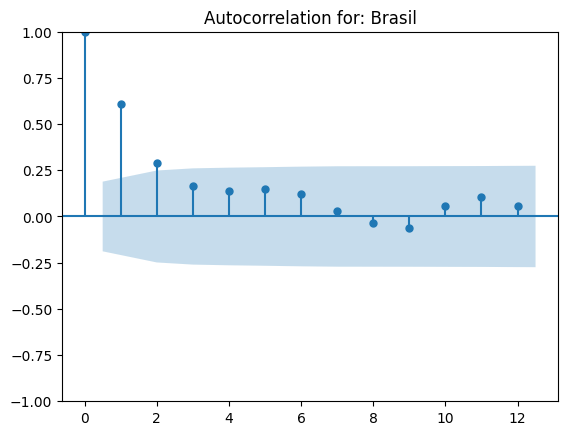

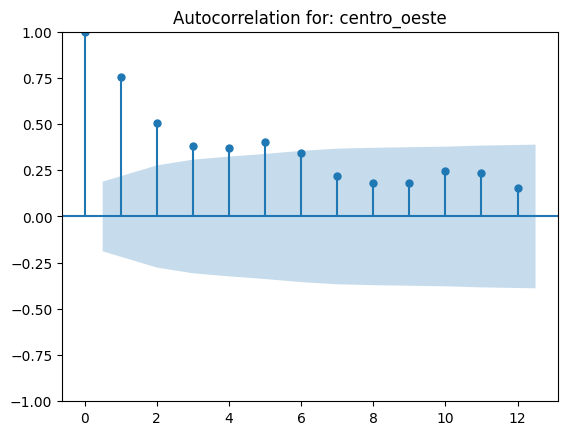

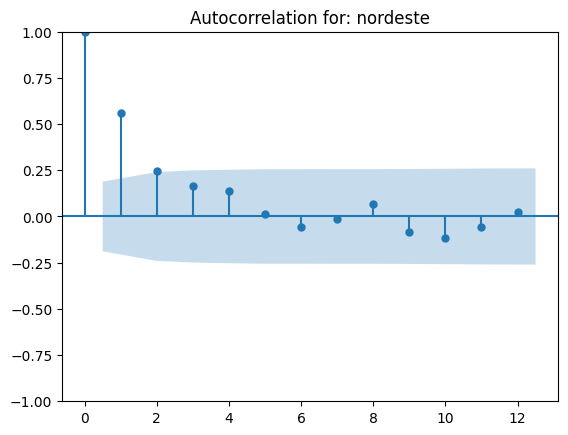

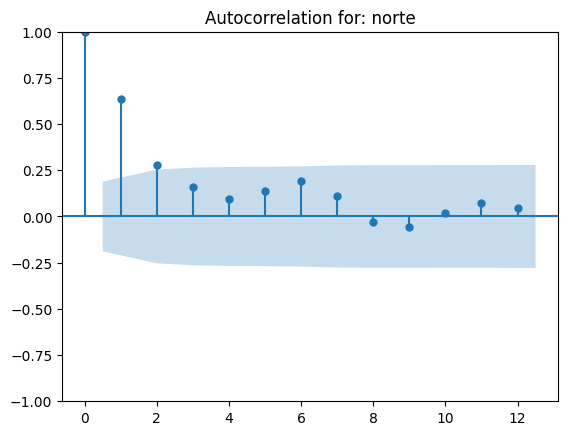

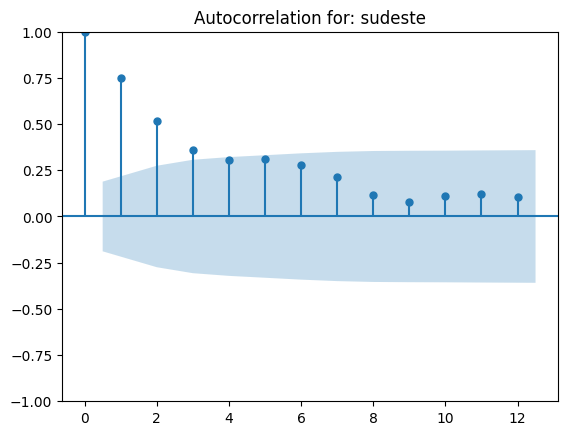

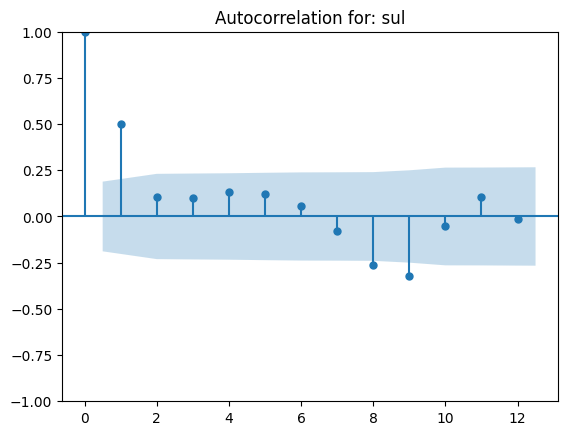

In [2377]:
if MODEL_DEF == 'GEE' or MODEL_DEF == "GLM":
    diagnostics_df = test_model_diagnostics(
    results=results,
    dataframe=RegressionDF,
    group_col=GROUP_COL_NAME,
    dependent_var=DEPENDENT_VAR,
    independent_var=INDEPENDENT_VAR
)
else:
    diagnostics_df = test_glsar_diagnostics(
    results=results, 
    dataframe=RegressionDF,
    group_col=GROUP_COL_NAME,
    dependent_var=DEPENDENT_VAR,
    independent_var=INDEPENDENT_VAR
)
    
diagnostics_df
    

# Export Results

In [2378]:
if MODEL_DEF == 'GLSAR':
    export_results(results,
        output_path = LOCAL_OUTPUT_PATH,
        processor_args = GLSAR_PROCESSOR_ARGS,
        preprocessor_args=PREPROCESSOR_ARGS,
        output_gsheet=output_wksheet,
    )

# Define Hover Graph Func


In [2379]:
def plot_with_all_dummies(
    variable: str,
    variable_df,
    results_obj,
    exclude_coeffs_by_prefix=None,
    plot_individual_effects=False,
    line_events=None, # Dict[str, Tuple[start, end, color, show_line]]
    slope_coef_str=None,
    real_serie_key=DEPENDENT_VAR,
    exponentite_coefs=False
):

    regression_stats = results_obj.params
    variable_df = variable_df.sort_values(by=DATE_NAME).reset_index(drop=True)
    dates = variable_df[DATE_NAME].values
    real_series = variable_df[real_serie_key].values

    slope_name = slope_coef_str if slope_coef_str else INDEPENDENT_VAR
    intercept = regression_stats.get("Intercept", 0)
    slope = regression_stats.get(slope_name, 0)
    t = np.arange(len(dates)) + 1


    #if exponentite_coefs:
        #slope = np.exp(slope) #if slope > 0 else slope
        #intercept = np.exp(intercept) if intercept > 0 else intercept
    baseline_log = (intercept + slope * t).astype(float)
    full_pred = baseline_log.copy()

    fig = go.Figure()

    baseline = np.exp(baseline_log) if exponentite_coefs else baseline_log
    fig.add_trace(go.Scatter(
        x=dates,
        y=baseline,
        mode='lines',
        name='Baseline',
        line=dict(dash='dot', color='black')
    ))

    fig.add_trace(go.Scatter(
        x=dates,
        y=real_series,
        mode='markers',
        name='Real',
        marker=dict(color='black')
    ))



    for dummy_name, coef in regression_stats.items():
        if dummy_name in {"Intercept", INDEPENDENT_VAR}:
            continue
        if slope_coef_str and dummy_name == slope_coef_str:
            continue

        if exclude_coeffs_by_prefix and any(dummy_name.startswith(prefix) for prefix in exclude_coeffs_by_prefix):
            continue

        if dummy_name in variable_df.columns:
            dummy_ts = variable_df[dummy_name].values
            dummy_effect = coef * dummy_ts
            full_pred += dummy_effect

            if plot_individual_effects:
                fig.add_trace(go.Scatter(
                    x=dates,
                    y=dummy_effect,
                    mode='lines',
                    name=f'Effect: {dummy_name}',
                    line=dict(dash='dash')
                ))

    if line_events:
        for line_dummy_name, (event_start_date, event_end_date, fillcolor, show_line) in line_events.items():
            if fillcolor:
                # Sombra para eventos tipo "pulse"
                fig.add_shape(
                    type="rect",
                    x0=event_start_date,
                    x1=event_end_date,
                    y0=0,
                    y1=1,
                    xref="x",
                    yref="paper",
                    fillcolor=fillcolor,
                    opacity=0.3,
                    layer="below",
                    line_width=0,
                )
        
            if show_line:
                # Linha e anotação para eventos como Pandemia e Pós-Pandemia
                fig.add_shape(
                    type="line",
                    x0=event_start_date,
                    x1=event_start_date,
                    y0=min(real_series),
                    y1=max(real_series),
                    line=dict(color="black", dash="dash")
                )
        
                # Anotação deslocada no eixo x
                fig.add_annotation(
                    x=event_start_date,
                    y=max(real_series),
                    text=f"{line_dummy_name}",
                    showarrow=True,
                    arrowhead=2,
                    ax=30,  # deslocamento lateral
                    ay=-40
                )

    full_pred = np.exp(full_pred) if exponentite_coefs else full_pred
    fig.add_trace(go.Scatter(
        x=dates,
        y=full_pred,
        mode='lines',
        name='Full model',
        line=dict(color='purple')
    ))



    fig.update_layout(
        title=variable,
        xaxis_title="Time",
        yaxis_title="Value",
        legend_title="Legend"
    )

    fig.show()


# EXEC --- Plot Graph

In [2380]:
for variable in results:
    variable_result = results[variable]
    variable_df = RegressionDF[RegressionDF[GROUP_COL_NAME] == variable]
    plot_with_all_dummies(variable,
                            variable_df,
                            variable_result,
                            exclude_coeffs_by_prefix=[
                                "month_",
                                'quarter_',
                                'sin','cos'
                                ],
                            line_events = {
                                #'Choque_Inicial':        [CHOQUE_INICIAL_START_DATE, CHOQUE_INICIAL_END_DATE, "rgba(0, 0, 0, 0.25)", False],
                                #'Lockdown_2021':         [SECONDLOCKDOWN_START_DATE, SECONDLOCKDOWN_END_DATE, "rgba(0, 0, 0, 0.25)", False],
                                'Pandemia':         [PANDEMIA_START_DATE, PANDEMIA_END_DATE, None, True],
                                'Pos Pandemia':      [POS_PANDEMIA_START_DATE, END_DATE, None, True]
                            },
                            real_serie_key=IR_VAR,
                            exponentite_coefs=MODEL_DEF == "GEE" or MODEL_DEF == "GLM",
                            #slope_coef_str='PrePandemia_Trend'



                            )
